# Проект "Анализ мобильного приложения "Ненужные вещи".

*Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.*

**Задача**

Выделение различающиеся по продуктовым метрикам (retention rate, время в приложении, частота совершения событий, конверсия с целевое действие contacts_show) группы пользователей на основе событий, которые они выполняют в мобильном приложении.

**Цель:**

<span style="color:red">Подготовить исследование поведения пользователей мобильного приложения "Ненужные вещи".</span>


[План работы(декомпозиция)]
<a id="head"></a>

1.Загрузка данных и изучение общей информации
   - 1.1 Поиск пропусков и дубликатов
    
2.Предобработка данных
   - 2.1 Переименование столбцов
   - 2.2 Изменение типа данных в столбце event_time
  
3.Исследовательский анализ данных
   - Период, в течении которого собирались данные
   - Количество уникальных пользователей
   - Типы событий в датасете
   - Выделение пользовательской сессии
   - Retention Rate
   - Conversion Rate
   - Конверсия в целевое действие — просмотр контактов
   - Частота действий
   
   
4.Сегментирование пользователей на основе событий
   - Расчёт Retention rate для групп
   - Расчёт Conversion Rate для групп
    
5.Проверка статистических гипотез
   Конверсия в просмотры контактов пользователей, которые перешли из разных источников(Google и Yandex) равна](#h_15)
   Группа пользователей,которая добавила объявление в избранное (favorites_add) имеет большую конверсию в целевое действие, чем другие пользователи]
   
6.Выводы и рекомендации

## Загрузка данных и изучение общей информации
<a id="h_1"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
import seaborn as sns
import math as mth
from scipy import stats as st
import math


<mark>Используем конструкцию try-except, чтобы избежать ошибок с загрузкой данных</mark>

In [2]:
try:
    events = pd.read_csv('datasets/mobile_dataset.csv')
    source = pd.read_csv('/datasets/mobile_soures.csv')
except:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
    source = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv') 


`Исследуем датасет events:`

In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [4]:
display(events.head(5), events.shape)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


(74197, 3)

<mark>Датасет `events` содержит в себе 3 столбца со временем события, именем события и id пользователя, совершившего событие.
    Первично посмотрев на данные,приходим к выводу, что в датасете events нужно поменять тип данных столбца event.time c object на datetime, а также привести название столбцов к стандартному виду </mark>

`Исследуем датасет source:`

In [5]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [6]:
display(source.head(5), events.shape)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


(74197, 3)

<mark>Датасет `source` содержит в себе 2 столбца c id пользователя и источник, с которого пользователь установил приложение.
    Менять типы данных здесь не требуется, приведём название стобца "userId" к стандартному виду. Ниже проверим датасеты на наличие дубликатов и пропусков.</mark>

In [7]:
print(source.duplicated().sum()) 
print(events.duplicated().sum())  

0
0


In [8]:
print(events.isna().sum())
print(source.isna().sum())

event.time    0
event.name    0
user.id       0
dtype: int64
userId    0
source    0
dtype: int64


<mark>Дубликатов и пропусков не обнаружено, переходим к предобработке.</mark>

## Предобработка данных
<a id="h_2"></a>

[К оглавлению](#head)

<mark>Переименуем столбцы</mark>

In [9]:
events.rename(columns={'event.time': 'event_time',\
                       'event.name': 'event_name',\
                       'user.id': 'user_id'}, inplace=True)

source.rename(columns={'userId': 'user_id'}, inplace=True)

<mark>Изменим тип данных в столбце event_time</mark>

In [10]:
events = events.astype({'event_time': 'datetime64[ns]'})
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Объеденим столбцы `contacts_show` и `show_contacts` и `search_1 — search_7`, так они по сути равнозначны.

In [11]:
events['event_name'] = events['event_name'].replace('show_contacts','contacts_show')

events['event_name'] = events['event_name'].replace('search_1','search')
events['event_name'] = events['event_name'].replace('search_2','search')
events['event_name'] = events['event_name'].replace('search_3','search')
events['event_name'] = events['event_name'].replace('search_4','search')
events['event_name'] = events['event_name'].replace('search_5','search')
events['event_name'] = events['event_name'].replace('search_6','search')
events['event_name'] = events['event_name'].replace('search_7','search')

print(events['event_name'].value_counts())

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64


`Общий вывод:`

**Мы получили два датасета с данными пользователей, совершивших действия в приложении "Ненужные вещи". Датасет `events` содержит в себе 3 столбца со временем события, именем события и id пользователя, совершившего событие, а датасет `source` содержит id пользователя и источник, с которого пользователь установил приложение. Была выполнена предобработка данных, а именно: приведение названий столбцов к стандартному виду; приведение стобца event_time к нужному типу данных; поиск пропусков и дубликатов. Пропуски и дубликаты обнаружены не были, можем приступать к исследовательскому анализу**

## Исследовательский анализ данных
<a id="h_6"></a>

[К оглавлению](#head)

<mark>Посмотрим на период, в течении которого собирались данные:</mark>

In [12]:
print(events['event_time'].min())
print(events['event_time'].max())

events['event_time'].describe(datetime_is_numeric=True)

2019-10-07 00:00:00.431357
2019-11-03 23:58:12.532487


count                            74197
mean     2019-10-21 15:32:09.039316992
min         2019-10-07 00:00:00.431357
25%      2019-10-14 22:04:27.791869952
50%      2019-10-22 00:26:56.715014912
75%      2019-10-28 12:35:53.023877120
max         2019-11-03 23:58:12.532487
Name: event_time, dtype: object

**Данные с `2019-10-07` по `2019-11-03`**

<mark>Какое количество уникальных пользователей?<mark>

In [13]:
events['user_id'].nunique()

4293

<mark>Какие типы событий есть в датасете?<mark>

In [14]:
list(events['event_name'].unique())
print(events['event_name'].value_counts())

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64


**Расшифровки событий:**

- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1 — search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

Наиболее распространённым событием является tips_show,photos_show,advert_open.Очень интересно буд
Возможно, нам понабится объеденить столбцы `contacts_show` и `show_contacts` и `search_1 — search_7`, в ходе работы будет яснее.

<mark>Выделение пользовательской сессии:<mark>

**Выясним,какой временной промежуток между совершением событий.**

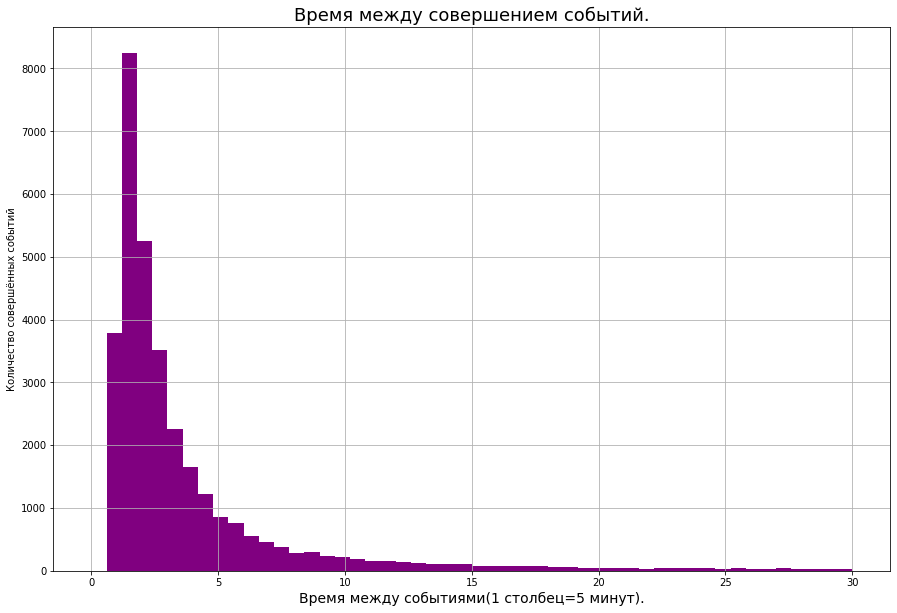

In [15]:
events.sort_values(by=['user_id', 'event_time'], inplace=True)

events['time_spent'] = events.groupby('user_id')['event_time'].diff(1)
distribution = events['time_spent'].dropna().dt.total_seconds().reset_index()
distribution['time_spent'] = distribution['time_spent'] / 60 

plt.figure(figsize=(15, 10))
ax = distribution.query('time_spent >= 1')['time_spent'].hist(bins=50, range=[0, 30],color='purple')
ax.set_title('Время между совершением событий.', fontsize=18)
ax.set_xlabel('Время между событиями(1 столбец=5 минут).', fontsize=14)
ax.set_ylabel('Количество совершённых событий');

In [16]:
events['time_spent'].describe(percentiles=[0.1,0.2,0.4,0.9,0.95,0.99])

count                        69904
mean     0 days 03:53:01.169952121
std      1 days 01:32:57.259354294
min         0 days 00:00:00.000001
10%      0 days 00:00:05.391409900
20%      0 days 00:00:15.767806800
40%      0 days 00:00:49.642757800
50%         0 days 00:01:10.535313
90%      0 days 00:17:00.807463700
95%      0 days 10:24:36.433909349
99%      4 days 22:14:04.256934480
max        26 days 13:49:54.853516
Name: time_spent, dtype: object

<mark>На основе построенной диаграмме распределения и последующего рассмотрения перцентилей, было принято решение взять время сессии в 20 минут.</mark>

In [17]:
g = (events.groupby('user_id')['event_time'].diff() > pd.Timedelta('20Min')).cumsum()
events['session_id'] = events.groupby(['user_id', g], sort=False).ngroup() + 1
events.sort_values(by=['user_id', 'event_time'], inplace=True)

**Посмотрим на распределение количества сессий по пользователям.**

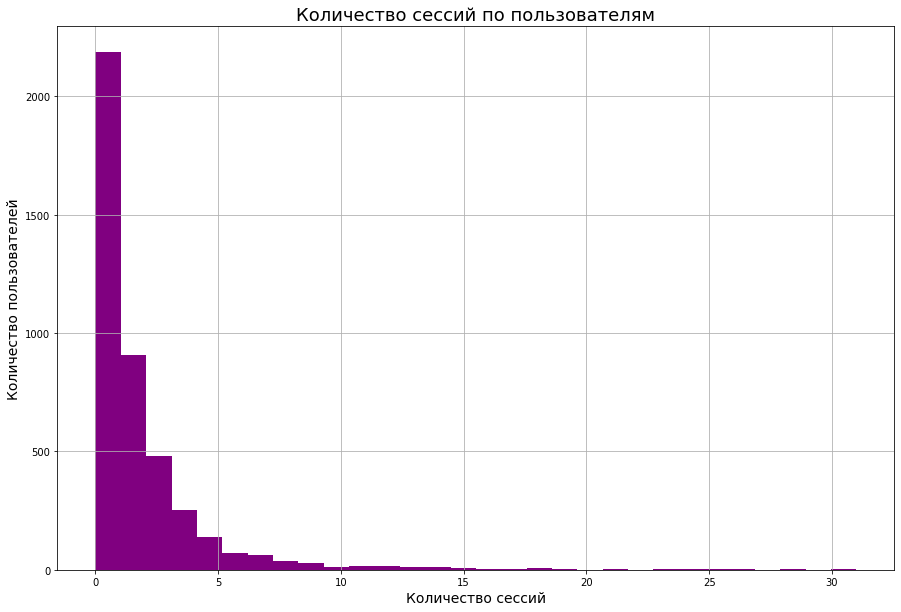

In [18]:
plt.figure(figsize=(15, 10))

ax = events.groupby('user_id', as_index=False).agg({'session_id': 'nunique'})['session_id'].hist(bins=30, range=[0, 31],color='purple')


ax.set_title('Количество сессий по пользователям', fontsize=18)
ax.set_ylabel('Количество пользователей', fontsize=14)
ax.set_xlabel('Количество сессий', fontsize=14);

**Посчитаем среднее и медиану**

In [19]:
print(events.groupby('user_id', as_index=False).agg({'session_id': 'nunique'})['session_id'].mean())
print(events.groupby('user_id', as_index=False).agg({'session_id': 'nunique'})['session_id'].median())

2.556487304914978
1.0


<mark>В собранных данных преобладают пользователи, которые совершили 1 сессию. В среднем на пользователя приходится 2.55 сессии,медианное же значение - 1 сессия.</mark>

### Retention Rate
<a id="h_7"></a>

<mark>Для расчёта Retention Rate воспользуемся функцией из теории, но перед этим создадим столбцы с данными о первой активности пользователей.</mark>

In [20]:
events.sort_values(by=['user_id', 'event_time'], inplace=True)

first_action = events.groupby('user_id', as_index=False).agg({'event_time': 'first'}).rename(columns={'event_time': 'first_ts'})
profiles = events.merge(first_action, how='left', on='user_id').copy()
# profiles.info()
profiles['dt'] =  pd.to_datetime(profiles['first_ts']).dt.date

profiles

,event_time,event_name,user_id,time_spent,session_id,first_ts,dt
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaT,1,2019-10-07 13:39:45.989359,2019-10-07
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:00:45.063550,1,2019-10-07 13:39:45.989359,2019-10-07
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:00:34.669580,1,2019-10-07 13:39:45.989359,2019-10-07
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:02:15.012972,1,2019-10-07 13:39:45.989359,2019-10-07
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:02:10.182041,1,2019-10-07 13:39:45.989359,2019-10-07
...,...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:00:27.886483,10975,2019-10-12 00:57:21.241896,2019-10-12
74193,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:00:33.940425,10975,2019-10-12 00:57:21.241896,2019-10-12
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:15:43.032080,10975,2019-10-12 00:57:21.241896,2019-10-12
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:00:37.270657,10975,2019-10-12 00:57:21.241896,2019-10-12


**Рассчитаем начало сессии**

In [21]:
session_start = profiles.groupby('session_id', as_index=False).agg({'event_time': 'first'}).rename(columns={'event_time': 'session_start'})

profiles = profiles.merge(session_start, how='left', on='session_id').copy() 
# profiles.info()
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
profiles

,event_time,event_name,user_id,time_spent,session_id,first_ts,dt,session_start
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaT,1,2019-10-07 13:39:45.989359,2019-10-07,2019-10-07 13:39:45.989359
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:00:45.063550,1,2019-10-07 13:39:45.989359,2019-10-07,2019-10-07 13:39:45.989359
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:00:34.669580,1,2019-10-07 13:39:45.989359,2019-10-07,2019-10-07 13:39:45.989359
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:02:15.012972,1,2019-10-07 13:39:45.989359,2019-10-07,2019-10-07 13:39:45.989359
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0 days 00:02:10.182041,1,2019-10-07 13:39:45.989359,2019-10-07,2019-10-07 13:39:45.989359
...,...,...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:00:27.886483,10975,2019-10-12 00:57:21.241896,2019-10-12,2019-11-03 15:36:01.007440
74193,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:00:33.940425,10975,2019-10-12 00:57:21.241896,2019-10-12,2019-11-03 15:36:01.007440
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:15:43.032080,10975,2019-10-12 00:57:21.241896,2019-10-12,2019-11-03 15:36:01.007440
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,0 days 00:00:37.270657,10975,2019-10-12 00:57:21.241896,2019-10-12,2019-11-03 15:36:01.007440


In [22]:
def get_retention(
    profiles, 
    observation_date, 
    horizon_days, 
    dimensions=[], 
    ignore_horizon=False
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

# получаем сырые данные и готовую таблицу



**Расчитаем Retention Rate по 14 дням лайфтайма для когорт с 7 по 21 число(с учетом горизонта анализа)**

In [23]:
retention_raw, retention = get_retention(
    profiles, datetime(2019, 11, 3).date(), 14, dimensions=['dt'], ignore_horizon=False
)
retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2019-10-07,204,1.0,0.117647,0.093137,0.107843,0.053922,0.034314,0.058824,0.078431,0.053922,0.049020,0.049020,0.034314,0.024510,0.058824
2019-10-08,167,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892,0.071856,0.053892,0.035928,0.059880,0.023952,0.029940,0.029940
2019-10-09,176,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818,0.073864,0.056818,0.034091,0.022727,0.028409,0.034091,0.056818
2019-10-10,174,1.0,0.086207,0.103448,0.080460,0.091954,0.080460,0.068966,0.051724,0.080460,0.034483,0.034483,0.051724,0.045977,0.040230
2019-10-11,136,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.066176,0.044118,0.014706,0.044118,0.036765,0.036765,0.051471,0.029412
2019-10-12,125,1.0,0.128000,0.160000,0.056000,0.064000,0.088000,0.080000,0.088000,0.080000,0.064000,0.064000,0.040000,0.072000,0.048000
2019-10-13,148,1.0,0.128378,0.067568,0.054054,0.067568,0.054054,0.054054,0.047297,0.047297,0.047297,0.040541,0.040541,0.047297,0.047297
2019-10-14,185,1.0,0.113514,0.102703,0.102703,0.081081,0.070270,0.048649,0.043243,0.075676,0.037838,0.037838,0.048649,0.016216,0.059459
2019-10-15,186,1.0,0.134409,0.086022,0.075269,0.053763,0.053763,0.080645,0.075269,0.064516,0.021505,0.037634,0.037634,0.032258,0.037634


**Построим тепловую карту**

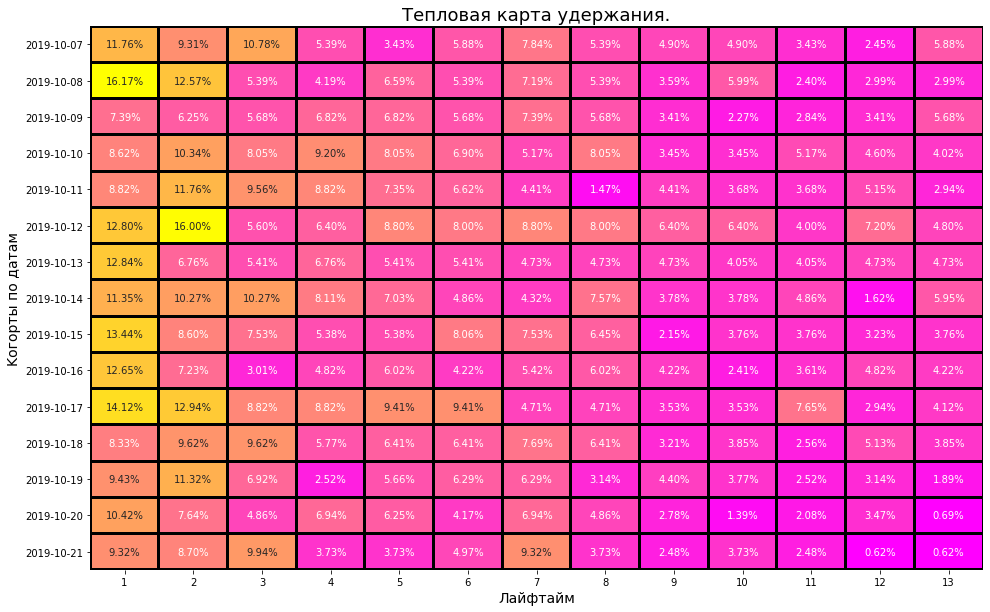

In [24]:


plt.figure(figsize=(16, 10))  
ax = sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  
    annot=True,  
    fmt='.2%',  
    cbar=False,
    cmap= 'spring',
    linewidths=2,
    linecolor='black'
)
ax.set_title('Тепловая карта удержания.', fontsize=18)
ax.set_ylabel('Kогорты по датам', fontsize=14)
ax.set_xlabel('Лайфтайм', fontsize=14);


### Конверсия

**Сначала мы расчитаем общую конверсию по проекту**

In [25]:
conversion_all = profiles.query('event_name=="contacts_show"').groupby('user_id').agg({'user_id': 'nunique'}).count() 
conversion_all_count = profiles.groupby('user_id').agg({'user_id': 'nunique'}).count()

print(f"Конверсия по проекту составляет: {(conversion_all / conversion_all_count)['user_id']}")

Конверсия по проекту составляет: 0.22851153039832284


In [26]:
time_action = profiles.query('event_name == "contacts_show"')[['user_id', 'event_time']]
time_action.rename(columns={'event_time': 'event_dt'}, inplace=True)
time_action

,user_id,event_dt
50,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:17:18.659799
54,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:23:11.839947
56,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:30:31.912891
60,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 20:04:53.349091
78,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29 21:26:40.258472
...,...,...
74173,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 14:38:51.134084
74175,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 14:41:24.780546
74177,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 14:42:26.444553
74188,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 15:48:05.420247


In [27]:
def get_conversion(
    profiles,
    time_action,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первого целевого действия для каждого пользователя
    first_act = (
        time_action.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о целевых действиях 
    result_raw = result_raw.merge(
        first_act[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждого целевого действия
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [28]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, time_action, datetime(2019, 11, 3).date(), 14)
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,2457,0.179894,0.186813,0.19129,0.196581,0.201872,0.205942,0.20757,0.209605,0.211233,0.214896,0.217745,0.218559,0.220187,0.221815


<Figure size 864x504 with 0 Axes>

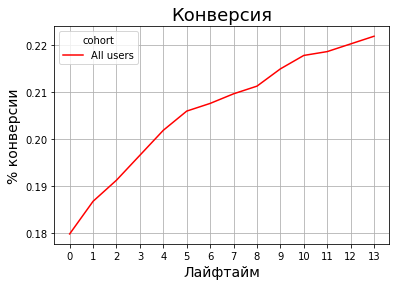

In [29]:
plt.figure(figsize=(12, 7))

report = conversion.drop(columns = ['cohort_size'])

ax =report.T.plot(grid=True, xticks=list(report.columns.values),color='r',) 

ax.set_title('Конверсия', fontsize=18)
ax.set_ylabel('% конверсии', fontsize=14)
ax.set_xlabel('Лайфтайм', fontsize=14);

plt.show()

### Конверсия в целевое действие — просмотр контактов
<a id="h_10"></a>

[К оглавлению](#head)

**Выводим конверсию целевого действия с остальными действиями пользователей**

1. `tips_show` → `contacts_show`

In [30]:
#количество пользователей, совершивших действие tips_show
tips_show = profiles.query('event_name == "tips_show"')['user_id']
tips_show.nunique()

2801

**Рекомендованные объявления посмотрели 2801 человек**

In [31]:
#количество пользователей, совершивших действие contacts_show
users_tips_show = profiles.query('user_id in @tips_show')

print(users_tips_show.query('event_name == "contacts_show"')['user_id'].nunique())

516


**516 пользователей,которые посмотрели рекомендованные объявления и посмотрели контакты**

In [32]:
#расчёт конверсии
round(users_tips_show.query('event_name == "contacts_show"')['user_id'].nunique() / users_tips_show['user_id'].nunique() * 100,2)

18.42

**Конверсия составляет 18.42%**

2. `advert_open` → `contacts_show`

In [33]:
#количество пользователей, совершивших действие advert_open
advert_open = profiles.query('event_name == "advert_open"')['user_id']
advert_open.nunique()

751

**Открыли карточку объявления 751 человек**

In [34]:
#количество пользователей, совершивших действие contacts_show
advert_open_users = profiles.query('user_id in @advert_open')

print(advert_open_users.query('event_name == "contacts_show"')['user_id'].nunique())

138


**138 пользователей открыли карточку объявления и посмотрели контакты**

In [35]:
#расчёт конверсии
round(advert_open_users.query('event_name == "contacts_show"')['user_id'].nunique() / advert_open_users['user_id'].nunique() * 100,2)

18.38

**Конверсия составляет 18.38%**

3. `photos_show` → `contacts_show`

In [36]:
#количество пользователей, совершивших действие photos_show
photos_show = profiles.query('event_name == "photos_show"')['user_id']
photos_show.nunique()

1095

**Посмотрели фотографию в объявлении 1095 человек**

In [37]:
#количество пользователей, совершивших действие contacts_show
photos_show_users = profiles.query('user_id in @photos_show')

print(photos_show_users.query('event_name == "contacts_show"')['user_id'].nunique())

339


**339 пользователей опосмотрели фотографию в объявлении и посмотрели контакты**

In [38]:
#расчёт конверсии
round(photos_show_users.query('event_name == "contacts_show"')['user_id'].nunique() / photos_show_users['user_id'].nunique() * 100,2)

30.96

**Конверсия составляет 30.96%**

4. `tips_click` → `contacts_show`

In [39]:
#количество пользователей, совершивших действие tips_click
tips_click = profiles.query('event_name == "tips_click"')['user_id']
tips_click.nunique()

322

**332 пользователя кликнули по рекомендованному объявлению**

In [40]:
#количество пользователей, совершивших действие contacts_show
tips_click_users = profiles.query('user_id in @tips_click')

print(tips_click_users.query('event_name == "contacts_show"')['user_id'].nunique())

100


**100 человек кликнули по рекомендованному объявлению и посмотрели контакты**

In [41]:
#расчёт конверсии
round(tips_click_users.query('event_name == "contacts_show"')['user_id'].nunique() / tips_click_users['user_id'].nunique() * 100,2)

31.06

**Конверсия составляет 31.06%**

5. `map` → `contacts_show`

In [42]:
#количество пользователей, совершивших действие map
map = profiles.query('event_name == "map"')['user_id']
map.nunique()

1456

**1456 пользователей открыли карту размещенных объявлений**

In [43]:
#количество пользователей, совершивших действие contacts_show
map_users = profiles.query('user_id in @map')

print(map_users.query('event_name == "contacts_show"')['user_id'].nunique())

289


**289 человек открыли карту размещенных объявлений и посмотрели контакты**

In [44]:
#расчёт конверсии
round(map_users.query('event_name == "contacts_show"')['user_id'].nunique() / map_users['user_id'].nunique() * 100,2)

19.85

**Конверсия составляет 19.85%**

5. `search` → `contacts_show`

In [45]:
#количество пользователей, совершивших действие search
search = profiles.query('event_name == "search"')['user_id']
search.nunique()

1666

**1666 осуществляли поиск по сайту**

In [46]:
#количество пользователей, совершивших действие contacts_show
search_users = profiles.query('user_id in @search')

print(map_users.query('event_name == "contacts_show"')['user_id'].nunique())

289


**289 осуществляли поиск по сайту и посмотрели контакты**

In [47]:
#расчёт конверсии
round(search_users.query('event_name == "contacts_show"')['user_id'].nunique() / search_users['user_id'].nunique() * 100,2)

22.63

**Конверсия составляет 22.63%**

6. `favorites_add` → `contacts_show`

In [48]:
#количество пользователей, совершивших действие favorites_add
favorites_add = profiles.query('event_name == "favorites_add"')['user_id']
favorites_add.nunique()

351

**351 пользователь добавил объявление в избранное**

In [49]:
#количество пользователей, совершивших действие contacts_show
favorites_add_users = profiles.query('user_id in @favorites_add')

print(favorites_add_users.query('event_name == "contacts_show"')['user_id'].nunique())

136


**136 пользователей добавили объявление в избранное и посмотрели контакты**

In [50]:
#расчёт конверсии
round(favorites_add_users.query('event_name == "contacts_show"')['user_id'].nunique() / favorites_add_users['user_id'].nunique() * 100,2)

38.75

**Конверсия составляет 38.75%**

`Вывод`

<mark>Самая большая конверсия в целевое действие(просмотр контактов) из действия "favorites_add" - добавление объявления в избранное(38.75%). На втором месте по конверсии действие "tips_click" 31.06%, а на третьем 'photos_show' 30.96%. Нам это говорит о том, что пользователи активно кликают на предложенные объявления, а также ознакамливаются с фотографиями в карточке. Пользователи, которые просто открывают объявления реже всего переходят в просмотры контактов - конверсия этих пользователей составляет 18.38%. 
    Вообще, конверсия из действия "favorites_add" меня не то что удивила, но захотелось попродробнее расмотреть этот момент в шаге со статистическими тестами<mark>


### Частота действий

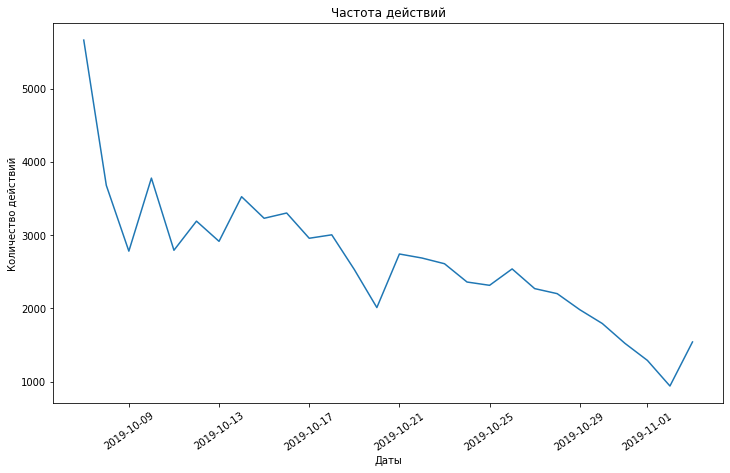

In [51]:
frequency = profiles.groupby('dt', as_index=False).agg({'event_name': 'count'})

plt.figure(figsize=(12, 7))

sns.lineplot(data=frequency, x='dt', y='event_name')
plt.title('Частота действий')
plt.ylabel('Количество действий')
plt.xlabel('Даты')
plt.xticks(rotation= 35);

**Хочу дополнительно взглянуть на среднюю и медианную продолжительность сессии**

In [52]:
session_end = profiles.groupby('session_id', as_index=False).agg({'event_time': 'last'}).rename(columns={'event_time': 'session_end'})

profiles = profiles.merge(session_end, how='left', on='session_id').copy() 

profiles['time_diff'] = (profiles['session_end']-profiles['session_start']).astype('timedelta64[m]')

In [53]:
profiles['time_diff'].value_counts()

0.0      5148
4.0      2178
2.0      2131
1.0      2087
3.0      2085
         ... 
96.0       34
104.0      32
118.0      29
135.0      27
79.0       25
Name: time_diff, Length: 126, dtype: int64

In [54]:
profiles.groupby('session_id', as_index=False).agg({'session_start': 'first', 'session_end': 'first', 'time_diff': 'first'})
session_duration_mean = profiles['time_diff'].mean().round(2)
session_duration_median = profiles['time_diff'].median().round(2)
print(f' Среднее время продолжительности сессии равно: {session_duration_mean} минут')
print(f' Медианное время продолжительности сессии равно: {session_duration_median} минут')

 Среднее время продолжительности сессии равно: 26.59 минут
 Медианное время продолжительности сессии равно: 18.0 минут


**У нас имеются "нулевые" сессии(длительность меньше минуты). Нужно посмотреть, какие действия совершались в такие сессии, возможно мы выявим технические неполадки**

In [55]:
profiles.query('time_diff == 0')['event_name'].value_counts()

tips_show        1783
photos_show      1177
search           1079
contacts_show     434
map               245
advert_open       220
contacts_call     110
favorites_add      69
tips_click         31
Name: event_name, dtype: int64

Большинство событий, которые длились менее 1 минуты - `tips_show`. Очевидно пользователям неинтересны рекомендованные объявления, а действие `tips_click`(пользователь кликнул по рекомендованному объявлению) - совершает ну очень мало юзеров в такие сессии.

`Общий вывод по исследовательскому анализу:`

<span style="color:red">Самое частое событие, с которым сталкиваются пользователи это `tips_show`. Наиболее частые временные интервалы между совершением действий - от 0 до 5 минут. Длительные интервалы между действиями встречаются довольно редко: визуализируя показатели удержания в когортах по дате с 2019-10-07 по 2019-10-21, можно заметить, что есть когорты с высоким и низким rr. Возможно, это зависит от качества трафика и рекламной кампании по привлечению пользователей в конкретный день. Конверсия в день 14 достигает 22%. Общий коэффициент конверсии составил 22,8%. Наши пользователи обычно не тратят больше минуты на просмотр рекомендованных объявлений или фотографий.</span>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Всё верно. Согласен с расчетом
</div>

### Сегментация

<mark>Я приняла решение сегментировать пользователей на основе источника, из которого они скачали наше приложение.
Мы проверим, влияет ли источник притока пользователей на показатели удержания или конверсии.<mark>
    `дополнение:`
    Возможно, источник может иметь высокий Retention Rate, но низкий Conversion Rate, что фактически сводит на нет высокий RR.

In [56]:
print(source.source.unique())
print(source.source.value_counts())

['other' 'yandex' 'google']
yandex    1934
other     1230
google    1129
Name: source, dtype: int64


In [57]:
profiles = profiles.merge(source, on='user_id', how='left')
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date

In [58]:
retention_raw, retention = get_retention(profiles, datetime(2019, 11, 3).date(), 14, 'source', ignore_horizon=False)
retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
source,,,,,,,,,,,,,,,
google,655,1.0,0.117557,0.090076,0.076336,0.054962,0.042748,0.070229,0.070229,0.053435,0.044275,0.042748,0.042748,0.042748,0.030534
other,688,1.0,0.101744,0.111919,0.068314,0.058140,0.081395,0.058140,0.056686,0.059593,0.033430,0.030523,0.034884,0.036337,0.050872
yandex,1114,1.0,0.114901,0.095153,0.078995,0.069120,0.064632,0.058348,0.067325,0.052962,0.036804,0.039497,0.035009,0.031418,0.035009


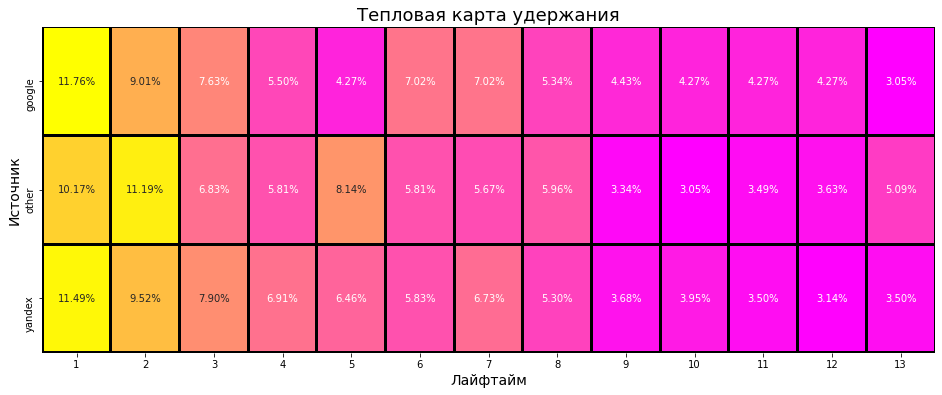

In [59]:
plt.figure(figsize=(16, 6))

ax = sns.heatmap(retention.drop(columns=['cohort_size', 0]),
                 annot=True,
                 fmt='.2%',
                 cbar=False,
                cmap= 'spring',
                linewidths=2,
                linecolor='black')
ax.set_title('Тепловая карта удержания', fontsize=18)
ax.set_ylabel('Источник', fontsize=14)
ax.set_xlabel('Лайфтайм', fontsize=14);

**Шок! Источник `others` на последний день лайфтайма показывает самый высокий показатель Retention Rate, хотя на первый день он наоборот был самым низким, а на 5 день показал резкий рост, очень интересно, что случилось в этот день. Вообще, стабильность здесь есть только у пользователей с источника `yandex`, хоть и выражается она стабильным падением удержания, но зато они на 14 день оказались на втором месте. Пользователи из `google` тоже удивили - их RR плавно снижался 5 дней, но на 6(и зафиксировался на 7) день лайфтайма подскочил вверх, но затем всё пошло на убыли и этот источник показал самый низкий показатель Retention Rate. Слишком много вопросов, давайте посмотрим на показатели конверсий этих групп**

In [60]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, time_action, datetime(2019, 11, 3).date(), 14, ['source']
)
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
source,,,,,,,,,,,,,,,
google,655,0.187786,0.192366,0.193893,0.201527,0.204580,0.207634,0.210687,0.212214,0.212214,0.216794,0.221374,0.221374,0.224427,0.224427
other,688,0.139535,0.149709,0.156977,0.158430,0.162791,0.167151,0.170058,0.171512,0.175872,0.181686,0.184593,0.184593,0.187500,0.188953
yandex,1114,0.200180,0.206463,0.210952,0.217235,0.224417,0.228905,0.228905,0.231598,0.232496,0.234291,0.236086,0.237882,0.237882,0.240575


<Figure size 1152x576 with 0 Axes>

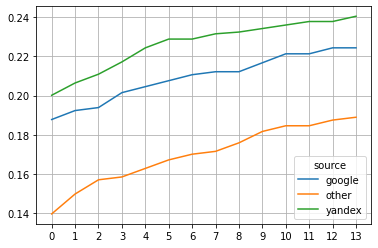

In [61]:
plt.figure(figsize = (16, 8)) 
report = conversion.drop(columns = ['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values)) 
ax.set_title('Конверсия по источникам', fontsize=18)
ax.set_ylabel('%', fontsize=14)
ax.set_xlabel('Лайфтайм', fontsize=14);
plt.show()

**Шок2! Пользователи из источника `other` имеют самые высокие показатели удержания, но самые низкие показатели конверсии. У `yandex`, напротив, они самые высокие. Сравнивая показатели конверсии и удержания, можно сделать вывод, что `yandex` является лидером по этим показателям (2 место по Retention Rate и 1 место по Conversion Rate).**

`Общий вывод по сегментации:`

<span style="color:red">Мы сегментировали пользователей по трём источникам,с которых пользователь установил приложение( `others`,`yandex`,`google`), чтобы проверить,влияет ли источник притока пользователей на показатели удержания или конверсии.
Открытия оказались впечатляющими: </span>
    
- Результаты RR показали, что лидирует источник `other`(5.09%), на втором месте `yandex`(3,50%), замыкает `google`(3.05%)(на 14 день).
- Расчёт и визуализация CR говорят о том, что конверсия пользователей с `google` (22%) и `yandex` (24%) превосходят `other`(18%)(на 14 день) 
    
**Перейдём к статистическим тестам, где мы проверим, есть ли статистически важная разница между конверсиями источников `yandex` и`google`**
    


### Проверка статистических гипотез

1. **Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверим гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.**

*Сформулируем нулевую и альтернативную гипотезу*

- `H₀`:  *статистически значимых различий между конверсиями пользователей из источников источников google, yandex, other нет*.
- `H₁`:  *статистически значимые различия между конверсиями пользователей из источников google, yandex, other есть.*

In [62]:
contacts_show_users = profiles.query('event_name =="contacts_show"').pivot_table(index='user_id',\
                                                                                 values='source',\
                                                                                 aggfunc='first').reset_index()

contacts_show_users_from_yandex = len(contacts_show_users.query('source =="yandex"')) 
contacts_show_users_from_google = len(contacts_show_users.query('source =="google"')) 
contacts_show_users_from_other = len(contacts_show_users.query('source =="other"')) 


all_users_source = profiles.pivot_table(index='user_id',\
                                        values='source',\
                                        aggfunc='first').reset_index()


all_users_from_yandex = len(all_users_source.query('source =="yandex"')) 
all_users_from_google = len(all_users_source.query('source =="google"')) 
all_users_from_other = len(all_users_source.query('source =="other"'))

In [63]:
def z_stat_test(successes, trials, alpha):  

    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    print(successes[0], successes[1], trials[0], trials[1])

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Перейдём к сравнению `Yandex` и `Google`:

In [64]:
yandex_und_google_comparison = [contacts_show_users_from_yandex, contacts_show_users_from_google]
all_user_yandex_und_google = [all_users_from_yandex, all_users_from_google]
z_stat_test(yandex_und_google_comparison, all_user_yandex_und_google, .05)

478 275 1934 1129
p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<mark>Разницы конверсий в группах яндекса и гугла не обнаружено</mark>

Сравним  `Yandex` и `Other`:

In [65]:
yandex_und_other_comparison = [contacts_show_users_from_yandex, contacts_show_users_from_other]
all_user_yandex_und_other = [all_users_from_yandex, all_users_from_other]
z_stat_test(yandex_und_other_comparison, all_user_yandex_und_other, .05)

478 228 1934 1230
p-значение:  4.7142597613403225e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


<mark>Между группами `Yandex` и `Other` имеется статистическая разность конверсий</mark>

Сравнениваем `Google` и `Other`:

In [66]:
google_und_other_comparison = [contacts_show_users_from_google, contacts_show_users_from_other]
all_user_google_und_other = [all_users_from_google, all_users_from_other]
z_stat_test(google_und_other_comparison, all_user_google_und_other, .05)

275 228 1129 1230
p-значение:  0.0005640941887214979
Отвергаем нулевую гипотезу: между долями есть значимая разница


<mark>Между группами `Google` и `Other` имеется статистическая разность конверсий</mark>

2. **На этапе расчёта конверсий в целевое действие, было принято решение рассмотреть пользователей, которые добавили карточку в избранное имеют большую конверсию в целевое действие в сравнении с группой, совершивших только contacts_show.**

*Итак, сформулируем нулевую и альтернативные гипотезы*

- `H₀`:  *статистически значимых различий между группой, совершивших действия favorites_add и contacts_show и группой, совершивших только contacts_show нет стат значимых различий.*.
- `H₁`:  *есть статистически значимые различия между группой, совершивших действия favorites_add и contacts_show и группой, совершивших только contacts_show.*

In [67]:
favorites_add_users = list(profiles.query('event_name=="favorites_add"')['user_id'].unique())
not_in_favorites_add_users = list(profiles.query('event_name!="favorites_add"')['user_id'].unique())

contacts_show_und_favorites_add = len(profiles.query('event_name =="contacts_show" and user_id in @favorites_add_users')['user_id'].unique())
contacts_show_und_not_favorites_add = len(profiles.query('event_name =="contacts_show" and user_id in @not_in_favorites_add_users')['user_id'].unique())

print(f'Пользователей, добавивших карточку объявления в избранное: {len(favorites_add_users)}, из них совершили целевое действие {contacts_show_und_favorites_add}')
print(f'Пользователей, не добавлявивших карточку объявления в избранное: {len(not_in_favorites_add_users)}, из них совершили целевое действие {contacts_show_und_not_favorites_add}')

Пользователей, добавивших карточку объявления в избранное: 351, из них совершили целевое действие 136
Пользователей, не добавлявивших карточку объявления в избранное: 4287, из них совершили целевое действие 981


**`Проведём тест`**

In [68]:
group = [contacts_show_und_favorites_add, contacts_show_und_not_favorites_add]
fav_and_not = [len(favorites_add_users), len(not_in_favorites_add_users)]
z_stat_test(group, fav_and_not, .05)

136 981 351 4287
p-значение:  2.3512747304721415e-11
Отвергаем нулевую гипотезу: между долями есть значимая разница


<mark>Данные говорят о том, что пользователи, добавившие объявление в избранное чаще соврешают целевое действие contacts_show. Статитстический тест подтвердил значимую разницу.</mark>

### Вывод:

*Данные взяты за период с 2019-10-07 по 2019-11-03. Столбцы в данных были переименованы. Пропусков и дубликатов не обнаружено.4293 уникальных пользователя пришли из трех различных источников: google, yandex и other. *

**Для работы с данными были определены сессии пользователей продолжительностью 20 минут. Также было рассчитано время начала и окончания каждой сессии. Дата первого действия каждого пользователя была определена для анализа когорты по датам.**

**В среднем каждый пользователь совершал 2,5 сеанса.**

**Сегментируя пользователей по источникам, мы видим, что показатели удержания варьируются в зависимости от источника:**

- google - 11,76% в первый день и 3% на 14 день.
- other - 10,17% в первый день и 5% на 14 день.
- yandex - 11,5% в первый день и 3,5% на 14 день.


**Сегментирование пользователей по тому же источнику дает следующие показатели конверсии:**

- yandex - 20% в первый день и 24% на 14 день.
- google - 19% в первый день и 22% на 14 день.
- other - 14% в первый день и 19% на 14 день.


**Таким образом, пользователи из источника yandex не имеют самого высокого показателя удержания, но у них самый высокий показатель конверсии, что статистически значимо по сравнению с источником "other".**


**Статистические тесты отвергают гипотезу о том, что разница в конверсии между группами пользователей из источников Яндекс и Google значительна: тот же тест между группами "yandex" и "other" и "google и other" показывает, что существует статистически значимая разница, т.е. эти группы пользователей показали разницу в конверсии.** 


**После проведения статистических тестов была подтверждена гипотеза о том, что пользователи, которые изначально добавили товар в избранное, с большей вероятностью совершат целевое действие contact_show по сравнению с пользователями, которые не добавили товар в избранное.*



**Рекомендация**.

- Пользователи с Яндекса имеют более высокие показатели удержания и конверсии, предлагаю отделу маркетинга финансировать именно этот источник. Так же на основе предоставленного мной исследования RR проанализировать и выснить, что повлияло на увеличение показателей источников 'other' и 'google'.


**Ссылка на презентацию:**
https://disk.yandex.ru/i/br27J8irpVNucQ

**Ссылка на дашборд**
https://public.tableau.com/app/profile/alyona.ryabinina/viz/2_16825615247120/2?publish=yes